In [51]:
import torch
import numpy as np
import torch.nn as nn

In [107]:
%load_ext autoreload
%autoreload 2

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

In [108]:
# pytorch disco imports
import utils_geom
import utils_vox

In [53]:
train_file_path = '/projects/katefgroup/shared_quant_models/controllers_data/files_on_which_did_not_work/visual_data_f99e19b8c4a729353deb88581ea8417a.npy'

In [54]:
data = np.load(train_file_path, allow_pickle=True).item()

In [55]:
print(data.keys())

dict_keys(['rgb_camXs', 'depth_camXs', 'intrinsics', 'extrinsics', 'camR_T_origin', 'bbox_in_ref_cam', 'rgb_camRs'])


In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
print(device)

cuda


In [58]:
# load the data, unproject and move to cuda, check what happens.
rgb_camXs = data['rgb_camXs']
rgb_camRs = data['rgb_camRs']
depth_camXs = data['depth_camXs']
intrinsics = data['intrinsics']
extrinsics = data['extrinsics']
camR_T_origin = data['camR_T_origin']
bbox_in_ref_cam = data['bbox_in_ref_cam']

In [59]:
print(rgb_camXs.shape)
print(rgb_camRs.shape)
print(depth_camXs.shape)
print(intrinsics.shape)
print(extrinsics.shape)
print(camR_T_origin.shape)
print(bbox_in_ref_cam.shape)

(51, 128, 128, 3)
(51, 128, 128, 3)
(51, 128, 128)
(51, 3, 3)
(51, 4, 4)
(4, 4)
(8, 3)


In [60]:
camR_T_origin = camR_T_origin.reshape(1, 4, 4)
camR_T_origin = np.tile(camR_T_origin, [51, 1, 1])
print(camR_T_origin.shape)

(51, 4, 4)


In [33]:
# plot all the images
def plot(imgs, total):
    # every row I will plot 10 images and number of rows are determined by the total
    n_rows = total // 10 + 1
    n_cols = 10
    fig_size = 2 * np.asarray([10, 2])
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True)
    j, k = 0,0
    for i in range(total):
        k = i%10
        if i % 10 == 0 and i != 0:
            j += 1
        axes[j][k].imshow(imgs[i])

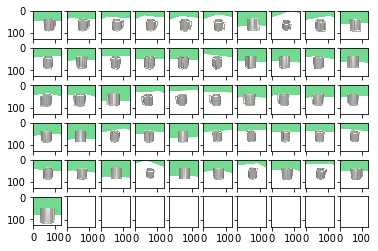

In [34]:
plot(rgb_camXs, len(rgb_camXs))

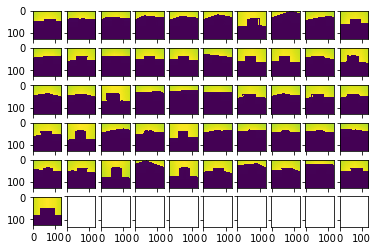

In [35]:
plot(depth_camXs, len(depth_camXs))

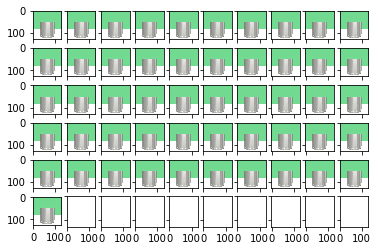

In [36]:
plot(rgb_camRs, len(rgb_camRs))

In [40]:
# check that none of the values are NONE
for i in range(len(rgb_camXs)):
    print(np.sum(rgb_camXs[i]), np.sum(depth_camXs[i]))

10129774 295279.62
10347005 258360.7
10511646 230827.36
10699889 203588.28
10609493 218537.89
10827527 190148.22
9708064 382505.4
11438424 115745.55
10580388 230864.72
9875964 351327.38
10284501 280173.25
9871660 345909.8
10323968 275042.16
9967717 323187.28
9883120 333707.16
10426762 255228.05
9733257 368323.4
9745196 371929.16
10151449 297071.3
9732917 376214.38
10191972 283279.56
10119171 290699.53
9671643 377601.3
10661022 206030.16
10914440 170349.1
10582652 221859.44
9968864 327667.06
10242385 282553.06
10011592 325467.25
10119209 309555.97
10003597 335225.0
9601498 427719.38
10581509 244156.11
10235598 299866.75
9739312 397605.28
10487885 263029.84
10548572 254947.02
10356846 282745.1
10409872 274082.06
10650789 239038.36
10185695 307844.12
10067401 330268.25
9483410 452294.2
11356843 130506.55
9590989 427368.78
10007091 337199.22
11010542 171686.69
10145887 302944.97
11067893 155189.66
10005357 320175.7
8890624 470784.25


In [41]:
# check intrinsics, extrinsics etc for nans or infs
for i in range(len(extrinsics)):
    print(np.sum(extrinsics[i]), np.sum(intrinsics[i]))

1.0443300287777932 438.01933598375615
0.9982221592928799 438.01933598375615
0.9135048591091928 438.01933598375615
0.845728056447248 438.01933598375615
0.6385047469806102 438.01933598375615
0.5900730328003088 438.01933598375615
-0.32326618576380795 438.01933598375615
0.6942692298040369 438.01933598375615
-0.0488491460738536 438.01933598375615
-0.6816881050978183 438.01933598375615
-0.5272504724285672 438.01933598375615
-0.9052657646592525 438.01933598375615
-0.7501890955659373 438.01933598375615
-1.0223513877242503 438.01933598375615
-1.1066852961664178 438.01933598375615
-1.003563151056304 438.01933598375615
-1.1540548194189997 438.01933598375615
-1.1115087399038093 438.01933598375615
-1.1005533098519225 438.01933598375615
-0.9404854525380133 438.01933598375615
-1.0040794182901671 438.01933598375615
-0.898926620419155 438.01933598375615
-0.46556017866540267 438.01933598375615
-0.8206171126742862 438.01933598375615
-0.7727140594190418 438.01933598375615
-0.5270659634205987 438.019335983

In [121]:
trgb_camXs = torch.from_numpy(rgb_camXs).permute(0, 3, 1, 2)
trgb_camRs = torch.from_numpy(rgb_camRs).permute(0, 3, 1, 2)
tdepth_camXs = torch.from_numpy(depth_camXs)
tpix_T_cams_ = torch.from_numpy(intrinsics)
torigin_T_camXs_ = torch.from_numpy(extrinsics)
tcamRs_T_origin = torch.from_numpy(camR_T_origin)

trgb_camXs = trgb_camXs / 255.
trgb_camXs = trgb_camXs - 0.5

trgb_camRs = trgb_camRs / 255.
trgb_camRs = trgb_camRs - 0.5

In [122]:
tcamRs_T_origin.shape
trgb_camXs.shape

torch.Size([51, 3, 128, 128])

In [123]:
torigin_T_camRs = torch.inverse(tcamRs_T_origin)
print(torigin_T_camRs.shape)

torch.Size([51, 4, 4])


In [124]:
# okay now I will try unprojecting going through it step by step
camRs_T_camXs_ = torch.matmul(utils_geom.safe_inverse(
            torigin_T_camRs), torigin_T_camXs_).float()
camXs_T_camRs_ = utils_geom.safe_inverse(camRs_T_camXs_).float()

In [125]:
pix_T_cams_ = utils_geom.pack_intrinsics(pix_T_cams_[:, 0, 0], pix_T_cams_[:, 1, 1], pix_T_cams_[:, 0, 2],
            pix_T_cams_[:, 1, 2]).cpu().float()

In [126]:
pix_T_camRs_ = torch.matmul(pix_T_cams_, camXs_T_camRs_)

In [127]:
print(pix_T_cams_.device)
print(pix_T_camRs_.device)

cpu
cpu


In [128]:
Z, Y, X = 32, 32, 32

In [148]:
# now one by one unproject the rgbs to volume and see if it is fine.
unpXs_ = list()
for x in range(len(trgb_camXs)):
    rgb_ = trgb_camXs[x].unsqueeze(0)
    pix_T_cam_ = pix_T_cams_[x].unsqueeze(0)
    unp_x = utils_vox.unproject_rgb_to_mem(rgb_, Z, Y, X, pix_T_cam_, device=torch.device('cpu'))
    unpXs_.append(unp_x)

In [136]:
unpRs_ = list()
for x in range(len(trgb_camXs)):
    rgb_ = trgb_camXs[x].unsqueeze(0)
    pix_T_cam = pix_T_camRs_[x].unsqueeze(0)
    unp_r = utils_vox.unproject_rgb_to_mem(rgb_, Z, Y, X, pix_T_cam_, device=torch.device('cpu'))
    unpRs_.append(unp_r)

## Now that I have made sure everything works on cpu I will now try the same thing on gpu

In [139]:
crgb_camXs = trgb_camXs.to(device)
crgb_camRs = trgb_camRs.to(device)
cdepth_camXs = tdepth_camXs.to(device)

In [140]:
camRs_T_camXs_ = camRs_T_camXs_.to(device)
camXs_T_camRs_ = camXs_T_camRs_.to(device)
pix_T_cams_ = pix_T_cams_.to(device)
pix_T_camRs_ = pix_T_camRs_.to(device)

In [145]:
# now do the unprojection step hopefully something will be stuck here
cuda_unpXs_ = list()
for x in range(len(crgb_camXs)):
    rgb_ = crgb_camXs[x].unsqueeze(0)
    pix_T_cam_ = pix_T_cams_[x].unsqueeze(0)
    unp_x = utils_vox.unproject_rgb_to_mem(rgb_, Z, Y, X, pix_T_cam_, device=device)
    cuda_unpXs_.append(unp_x)

In [146]:
cuda_unpRs_ = list()
for x in range(len(crgb_camXs)):
    rgb_ = crgb_camXs[x].unsqueeze(0)
    pix_T_cam_ = pix_T_cams_[x].unsqueeze(0)
    unp_r = utils_vox.unproject_rgb_to_mem(rgb_, Z, Y, X, pix_T_cam_, device=device)
    cuda_unpRs_.append(unp_r)